In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, LSTM, Bidirectional, Embedding,
    Multiply, Softmax, Lambda
)
from tensorflow.keras.optimizers import Adam

# 1. Cargar dataset
url = 'https://raw.githubusercontent.com/dD2405/Twitter_Sentiment_Analysis/master/train.csv'
csv_path = tf.keras.utils.get_file("twitter_sentiment.csv", url)
df = pd.read_csv(csv_path)
tweets = df['tweet']
labels = df['label']

# 2. Tokenización y padding
max_features = 10000
maxlen = 300

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(tweets)
sequences = tokenizer.texts_to_sequences(tweets)

x_data = pad_sequences(sequences, maxlen=maxlen)
y_data = labels.values

# 3. Split Train/Test
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, random_state=42, stratify=y_data
)

# 4. Oversampling con RandomOverSampler
ros = RandomOverSampler(random_state=42)
x_resampled, y_resampled = ros.fit_resample(x_train, y_train)

# 5. Modelo BiLSTM con atención (corregido con Lambda)
def BiLSTM_con_atencion(ventana, vocab_size, embedding_dim=128):
    inputs = Input(shape=(ventana,))
    embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=ventana)(inputs)

    lstm_out = Bidirectional(LSTM(64, return_sequences=True))(embedding)

    attention_weights = Dense(1, activation='tanh')(lstm_out)
    attention_weights = Softmax(axis=1)(attention_weights)

    attended = Multiply()([lstm_out, attention_weights])

    # Usamos Lambda para aplicar tf.reduce_sum correctamente
    context_vector = Lambda(lambda x: tf.reduce_sum(x, axis=1))(attended)

    output = Dense(1, activation='sigmoid')(context_vector)
    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 6. Entrenamiento
modelo = BiLSTM_con_atencion(ventana=maxlen, vocab_size=max_features)
history = modelo.fit(x_resampled, y_resampled, batch_size=64, epochs=10, validation_split=0.2)

# 7. Evaluación
loss, accuracy = modelo.evaluate(x_test, y_test)
print(f"Loss: {loss:.4f} - Accuracy: {accuracy:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
595/595 ━━━━━━━━━━━━━━━━━━━━ 424s 704ms/step - accuracy: 0.7529 - loss: 0.4782 - val_accuracy: 0.9511 - val_loss: 0.1846
Epoch 2/10
595/595 ━━━━━━━━━━━━━━━━━━━━ 452s 720ms/step - accuracy: 0.9760 - loss: 0.0835 - val_accuracy: 0.9706 - val_loss: 0.1174
Epoch 3/10
595/595 ━━━━━━━━━━━━━━━━━━━━ 422s 709ms/step - accuracy: 0.9898 - loss: 0.0391 - val_accuracy: 0.9727 - val_loss: 0.0990
Epoch 4/10
595/595 ━━━━━━━━━━━━━━━━━━━━ 451s 724ms/step - accuracy: 0.9936 - loss: 0.0252 - val_accuracy: 0.9897 - val_loss: 0.0381
Epoch 5/10
595/595 ━━━━━━━━━━━━━━━━━━━━ 440s 721ms/step - accuracy: 0.9954 - loss: 0.0187 - val_accuracy: 0.9947 - val_loss: 0.0208
Epoch 6/10
595/595 ━━━━━━━━━━━━━━━━━━━━ 445s 727ms/step - accuracy: 0.9974 - loss: 0.0099 - val_accuracy: 0.9979 - val_loss: 0.0143
Epoch 7/10
595/595 ━━━━━━━━━━━━━━━━━━━━ 441s 725ms/step - accuracy: 0.9977 - loss: 0.0111 - val_accuracy: 0.9962 - val_loss: 0.0190
Epoch 8/10
595/595 ━━━━━━━━━━━━━━━━━━━━ 441s 725ms/step - accuracy: 0.9980 -

In [ ]:
model.summary()

200/200 ━━━━━━━━━━━━━━━━━━━━ 23s 115ms/step
Reporte de clasificación:

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      5945
           1       0.72      0.62      0.67       448

    accuracy                           0.96      6393
   macro avg       0.85      0.80      0.82      6393
weighted avg       0.95      0.96      0.96      6393



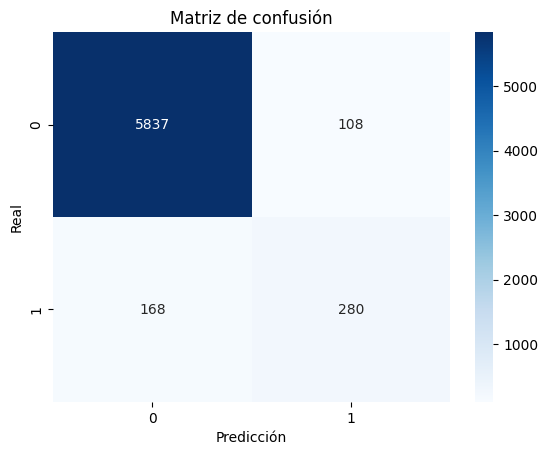

In [9]:
from sklearn.metrics import classification_report, confusion_matrix

# Generar predicciones (con umbral de 0.5)
#y_pred = (model.predict(X_test) > 0.5).astype("int32")
y_pred = (modelo.predict(x_test) > 0.3).astype("int32")  # umbral ajustado

# Reporte de clasificación
print("Reporte de clasificación:\n")
print(classification_report(y_test, y_pred))

# Matriz de confusión (opcional)
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()